# David Brown
# MIS581 Portfolio Project
# Logistic Regression to Predict Ten Year CHD Risk
# 2022-06-30


In [1]:
#Connect to Google drive to import dataset.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
sns.set_style('white')
%matplotlib inline

In [3]:
# Read in framingham.csv dataset
path = "/content/drive/MyDrive/MIS581/framingham.csv"
df = pd.read_csv(path)  #Original
dfI = df # For imputation of missing values
# First 5 rows
dfI.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

# Data Cleaning

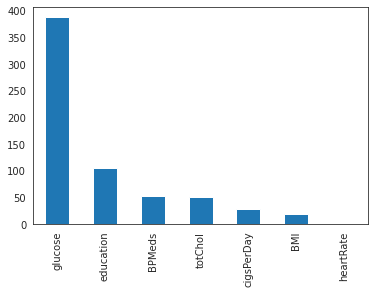

In [4]:
#Visualize Null Values
(df.isna()
 .sum()
 .sort_values(ascending=False)
 .where(lambda x: x>0)
 .dropna()
 .plot(kind='bar')
)
plt.show()

In [5]:
# Null value assessment table
dfI.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [6]:
# Impute missing data
# Impute data for missing values. Using mode for categorical data
# and median for continuous variables
dfI['education'] = dfI['education'].fillna(dfI['education'].mode()[0])
dfI['cigsPerDay'] = round(dfI['cigsPerDay'].fillna(dfI['cigsPerDay'].median())) # Dist negatively skewed
dfI['BPMeds'] = dfI['BPMeds'].fillna(dfI['BPMeds'].mode()[0])
dfI['totChol'] = dfI['totChol'].fillna(dfI['totChol'].median()) #  Dist negatively skewed
dfI['BMI'] = dfI['BMI'].fillna(dfI['BMI'].median()) # High positive outliers
dfI['heartRate'] = dfI['heartRate'].fillna(dfI['heartRate'].mean()) # Normal distribution
dfI['glucose'] = dfI['glucose'].fillna(dfI['glucose'].median()) 
# Null value assessment
dfI.isnull().sum() #Confirm no missing values

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

# Subset Data by Variable Type

In [7]:
cat = dfI[["male", "education", "currentSmoker","BPMeds", "prevalentStroke", "prevalentHyp", "diabetes", "TenYearCHD"]]
cont = dfI[["cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose", "age"]]

# Descriptive Statistics

In [8]:
dfI.describe(include="all").transpose()

count        mean        std     min     25%    50%  \
male             4238.0    0.429212   0.495022    0.00    0.00    0.0   
age              4238.0   49.584946   8.572160   32.00   42.00   49.0   
education        4238.0    1.954696   1.018510    1.00    1.00    2.0   
currentSmoker    4238.0    0.494101   0.500024    0.00    0.00    0.0   
cigsPerDay       4238.0    8.941482  11.902399    0.00    0.00    0.0   
BPMeds           4238.0    0.029259   0.168552    0.00    0.00    0.0   
prevalentStroke  4238.0    0.005899   0.076587    0.00    0.00    0.0   
prevalentHyp     4238.0    0.310524   0.462763    0.00    0.00    0.0   
diabetes         4238.0    0.025720   0.158316    0.00    0.00    0.0   
totChol          4238.0  236.689476  44.327427  107.00  206.00  234.0   
sysBP            4238.0  132.352407  22.038097   83.50  117.00  128.0   
diaBP            4238.0   82.893464  11.910850   48.00   75.00   82.0   
BMI              4238.0   25.800205   4.071041   15.54   23.08   25.4   
heartRate        4238.0   75.878924  12.025177   44.00   68.00   75.0   
glucose          4238.0   81.603587  22.865246   40.00   72.00   78.0   
TenYearCHD       4238.0    0.151958   0.359023    0.00    0.00    0.0   

                      75%    max  
male               1.0000    1.0  
age               56.0000   70.0  
education          3.0000    4.0  
currentSmoker      1.0000    1.0  
cigsPerDay        20.0000   70.0  
BPMeds             0.0000    1.0  
prevalentStroke    0.0000    1.0  
prevalentHyp       1.0000    1.0  
diabetes           0.0000    1.0  
totChol          262.0000  696.0  
sysBP            144.0000  295.0  
diaBP             89.8750  142.5  
BMI               28.0375   56.8  
heartRate         83.0000  143.0  
glucose           85.0000  394.0  
TenYearCHD         0.0000    1.0

In [9]:
# Continuous Variables
cont.describe().T

count        mean        std     min     25%    50%       75%  \
cigsPerDay  4238.0    8.941482  11.902399    0.00    0.00    0.0   20.0000   
totChol     4238.0  236.689476  44.327427  107.00  206.00  234.0  262.0000   
sysBP       4238.0  132.352407  22.038097   83.50  117.00  128.0  144.0000   
diaBP       4238.0   82.893464  11.910850   48.00   75.00   82.0   89.8750   
BMI         4238.0   25.800205   4.071041   15.54   23.08   25.4   28.0375   
heartRate   4238.0   75.878924  12.025177   44.00   68.00   75.0   83.0000   
glucose     4238.0   81.603587  22.865246   40.00   72.00   78.0   85.0000   
age         4238.0   49.584946   8.572160   32.00   42.00   49.0   56.0000   

              max  
cigsPerDay   70.0  
totChol     696.0  
sysBP       295.0  
diaBP       142.5  
BMI          56.8  
heartRate   143.0  
glucose     394.0  
age          70.0

# Correlation Analysis of Variables


In [10]:
# Correlation of all categorical variables with TenYearCHD
cat.corr()["TenYearCHD"].sort_values(ascending=False)

TenYearCHD         1.000000
prevalentHyp       0.177603
diabetes           0.097317
male               0.088428
BPMeds             0.086417
prevalentStroke    0.061810
currentSmoker      0.019456
education         -0.052812
Name: TenYearCHD, dtype: float64

In [ ]:
# Correlation of all continous variables with TenYearCVD
contplusten = dfI[["cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose", "age","TenYearCHD"]]
contplusten.corr()["TenYearCHD"].sort_values(ascending=False)

TenYearCHD    1.000000
age           0.225256
sysBP         0.216429
diaBP         0.145299
glucose       0.121277
totChol       0.081566
BMI           0.074217
cigsPerDay    0.058859
heartRate     0.022898
Name: TenYearCHD, dtype: float64

In [11]:
# Education vs Smoking Crosstabulation for Counts
cat1 = dfI['education'] 
cat2 = dfI['currentSmoker']
ct = pd.crosstab(cat1,cat2,margins=True)
ct.columns = ['NonSmoker','Smoker','RowTotals']
ct.index = ['HS','College','BS','Grad','ColumnTotals']
observed = ct.iloc[0:4,0:2]
ct

NonSmoker  Smoker  RowTotals
HS                  971     854       1825
College             574     679       1253
BS                  366     321        687
Grad                233     240        473
ColumnTotals       2144    2094       4238

In [12]:
# Chi square critical value 
crit = scipy.stats.chi2.ppf(q=0.95,df=3)
print('Critical Value for p = 0.05 and df = 3: ',crit)
# 18.76 > 7.81 and p < 0.05, thus, reject the null

Critical Value for p = 0.05 and df = 3:  7.814727903251179


In [13]:
# Chi Square Test of Independence results P-value < 0.05 and critical value > 7.81 = Reject Null
chi_ed_smk = scipy.stats.chi2_contingency(observed=observed)
print(chi_ed_smk)
print('Critical value > 7.81 and P-value < 0.05 = Reject Null')

(18.763607803459568, 0.00030595695448474945, 3, array([[923.26569136, 901.73430864],
       [633.89145824, 619.10854176],
       [347.55261916, 339.44738084],
       [239.29023124, 233.70976876]]))
Critical value > 7.81 and P-value < 0.05 = Reject Null


In [14]:
# Education vs Diabetes Crosstabulation for Counts
cat2 = dfI['diabetes']
ct1 = pd.crosstab(cat1,cat2,margins=True)
ct1.columns = ['NoDiabetes','Diabetes','RowTotals']
ct1.index = ['HS','College','BS','Grad','ColumnTotals']
observed1 = ct1.iloc[0:4,0:2]
ct1

NoDiabetes  Diabetes  RowTotals
HS                  1762        63       1825
College             1230        23       1253
BS                   673        14        687
Grad                 464         9        473
ColumnTotals        4129       109       4238

In [15]:
# Chi Square Test of Independence results 
# P-value < 0.05 and critical value > 7.81 = Reject Null
chi_ed_dm = scipy.stats.chi2_contingency(observed=observed1)
print(chi_ed_dm)
print('Critical value > 7.81 and P-value < 0.05 = Reject Null')

(9.980055820837169, 0.018736431290408313, 3, array([[1778.06158565,   46.93841435],
       [1220.7732421 ,   32.2267579 ],
       [ 669.33058046,   17.66941954],
       [ 460.83459179,   12.16540821]]))
Critical value > 7.81 and P-value < 0.05 = Reject Null


# One-Way ANOVA

In [16]:
# Education vs BMI One-Way Analysis of Variance
from scipy.stats.stats import F_onewayResult
from scipy.stats import f_oneway
oa_result = f_oneway(dfI.BMI, dfI.education)
print('One-Way ANOVA = ', oa_result, '**Reject Null of P < 0.05')


One-Way ANOVA =  F_onewayResult(statistic=136834.81803592702, pvalue=0.0) **Reject Null of P < 0.05


# Data Visualization - Exploratory Analysis

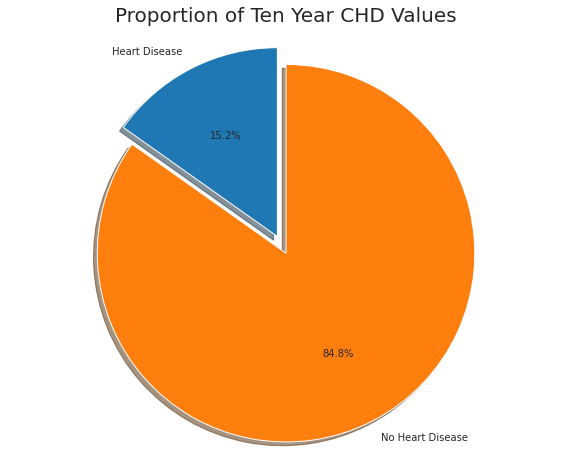

In [18]:
labels = 'Heart Disease', 'No Heart Disease'
sizes = [dfI.TenYearCHD[dfI["TenYearCHD"]==1].count(), dfI.TenYearCHD[dfI["TenYearCHD"]==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Ten Year CHD Values", size = 20)
plt.show()

Text(0.5, 1.0, 'Heart Disease by Male')

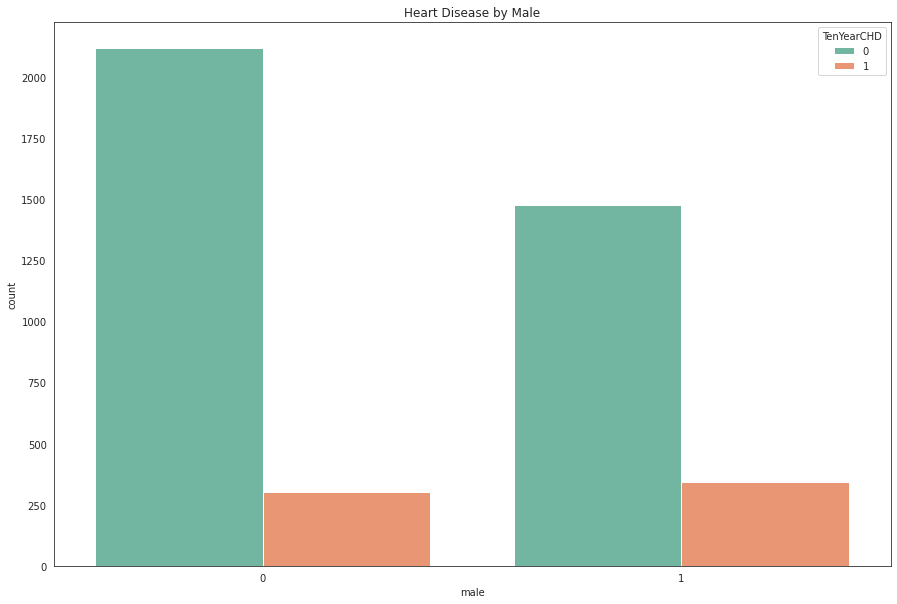

In [19]:
plt.figure(figsize=(15,10))
sns.countplot(x="male",hue="TenYearCHD", data=dfI, palette="Set2")
plt.title("Heart Disease by Male")

Text(0.5, 1.0, 'Heart Disease by Systolic Blood Pressure ')

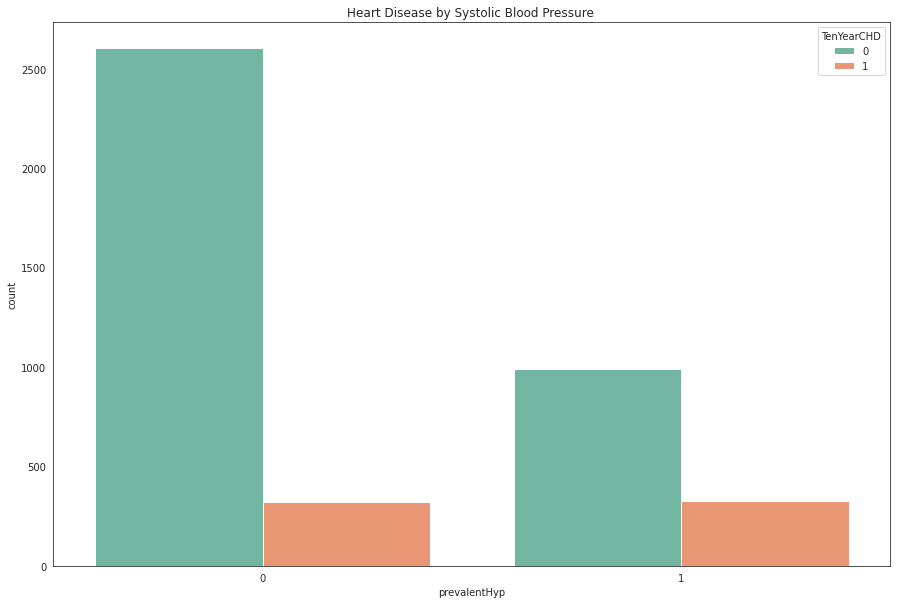

In [20]:
plt.figure(figsize=(15,10))
sns.countplot(x="prevalentHyp", hue="TenYearCHD", data=dfI,palette="Set2")
plt.title("Heart Disease by Systolic Blood Pressure ")

Text(0.5, 1.0, 'Ten Year CHD by Education ')

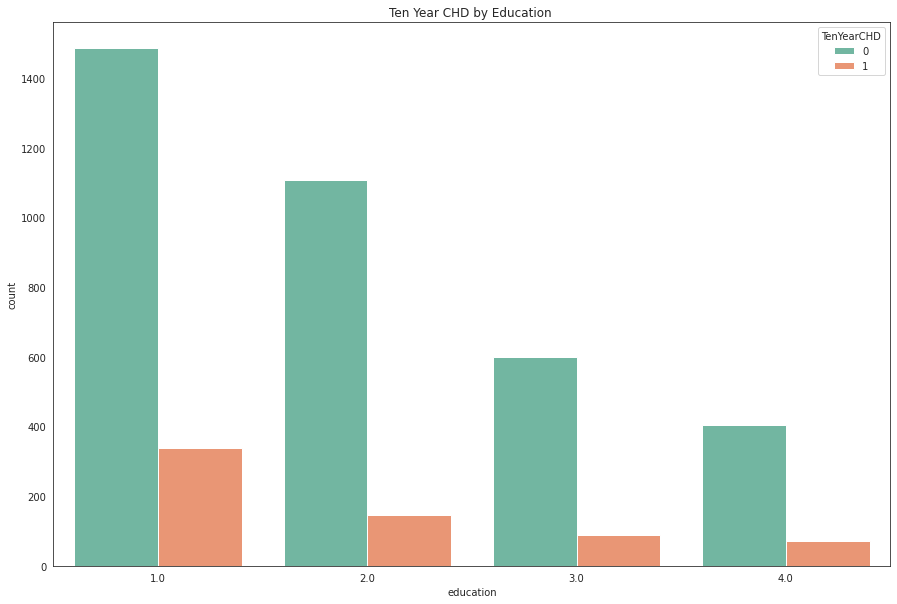

In [21]:
plt.figure(figsize=(15,10))
sns.countplot(x="education", hue="TenYearCHD", data=dfI,palette="Set2")
plt.title("Ten Year CHD by Education ")

Text(0.5, 1.0, 'Ten Year CHD by Education ')

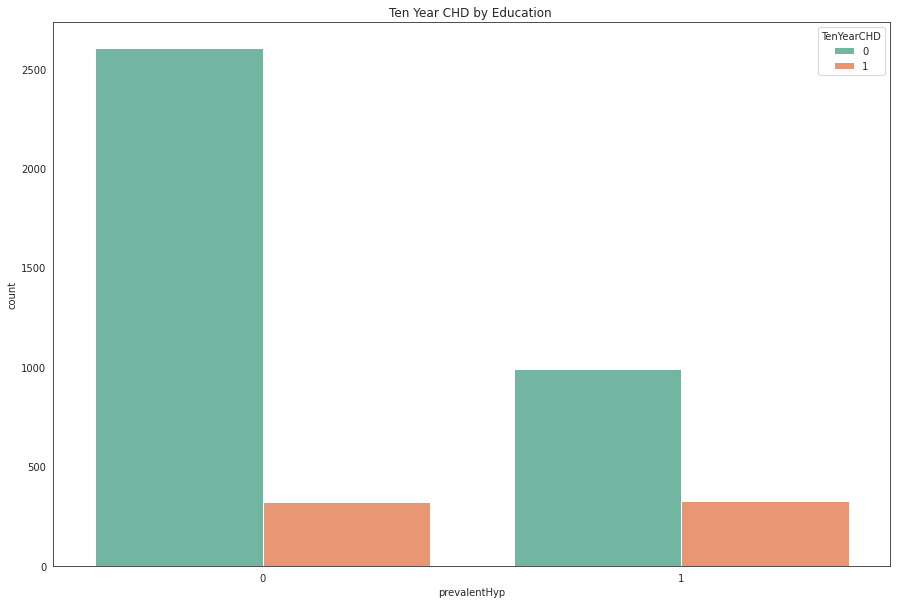

In [22]:
plt.figure(figsize=(15,10))
sns.countplot(x="prevalentHyp", hue="TenYearCHD", data=dfI,palette="Set2")
plt.title("Ten Year CHD by Education ")

Text(0.5, 1.0, 'Ten Year CHD by Gender ')

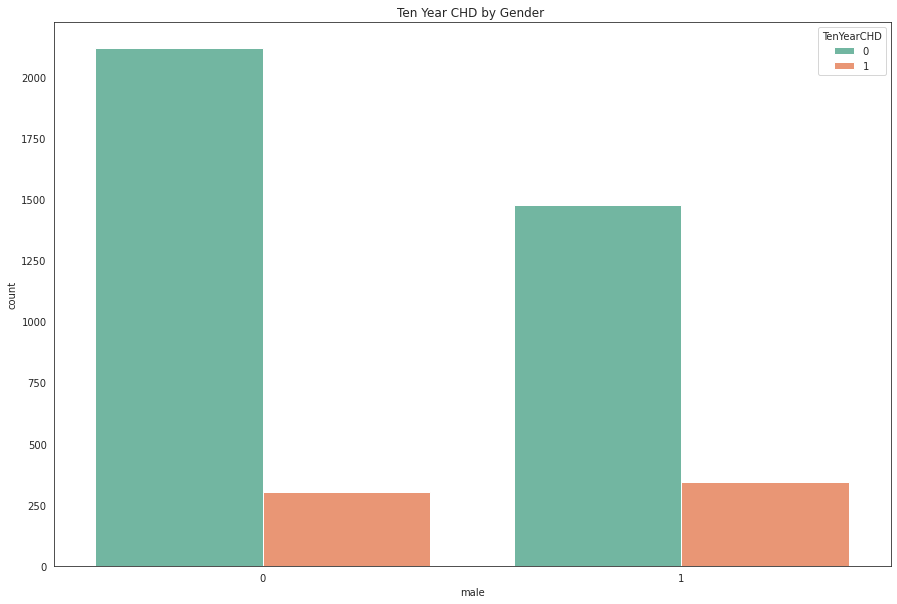

In [23]:
plt.figure(figsize=(15,10))
sns.countplot(x="male", hue="TenYearCHD", data=dfI,palette="Set2")
plt.title("Ten Year CHD by Gender ")

In [24]:
import plotly.graph_objects as go
labels = dfI['male'].unique()
values = dfI['male'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text="<b>Gender</b>")
fig.show()

# **LOGISTIC REGRESSION**

# Data Normalization

In [25]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
dfI[["cigsPerDay","totChol","sysBP","diaBP","BMI","heartRate","glucose","age"]]= ss.fit_transform(df[["cigsPerDay","totChol","sysBP","diaBP","BMI","heartRate","glucose","age"]])
dfI.head(3)

male       age  education  currentSmoker  cigsPerDay  BPMeds  \
0     1 -1.234951        4.0              0   -0.751322     0.0   
1     0 -0.418257        2.0              0   -0.751322     0.0   
2     1 -0.184916        1.0              1    0.929210     0.0   

   prevalentStroke  prevalentHyp  diabetes   totChol     sysBP     diaBP  \
0                0             0         0 -0.940600 -1.195907 -1.082625   
1                0             0         0  0.300313 -0.515187 -0.158988   
2                0             0         0  0.187503 -0.220209 -0.242955   

        BMI  heartRate   glucose  TenYearCHD  
0  0.287379   0.342744 -0.201359           0  
1  0.719752   1.590275 -0.245099           0  
2 -0.113057  -0.073099 -0.507537           0

# Data Partitioning

In [26]:
X = dfI.drop("TenYearCHD",axis=1)
y = dfI["TenYearCHD"]
print(X.columns)
print(y)

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose'],
      dtype='object')
0       0
1       0
2       0
3       1
4       0
       ..
4233    1
4234    0
4235    0
4236    0
4237    0
Name: TenYearCHD, Length: 4238, dtype: int64


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3390, 15)
(848, 15)
(3390,)
(848,)


# Supervised Training of Logistic Regression Model

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)

[[ 0.4239869   0.57387679  0.03907334 -0.0399474   0.28891091  0.24144129
   0.76191997  0.19595146  0.01433754  0.03857695  0.30847802  0.02008899
  -0.01925855 -0.06542558  0.18782535]]
[-2.27702639]


In [29]:
#Model Prediction
predictions = model.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[718   6]
 [115   9]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.60      0.07      0.13       124

    accuracy                           0.86       848
   macro avg       0.73      0.53      0.53       848
weighted avg       0.82      0.86      0.81       848

0.8573113207547169


In [31]:
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(dfI, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')

In [33]:
valid_col = ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']

In [34]:
target_col = 'TenYearCHD'

In [35]:
model.fit(train_df[valid_col], train_df[target_col])

LogisticRegression(solver='liblinear')

In [36]:
model.coef_.tolist()

[[0.3656910353301382,
  0.5113947389347042,
  0.006818285551706747,
  -0.1555909216079359,
  0.3538630801797799,
  0.6016006933555422,
  0.7940552896070204,
  0.15816099432986097,
  0.28503188553785,
  0.09075706529305082,
  0.32838936198033875,
  0.004427660647586862,
  -0.025155229153575657,
  -0.03949100527056743,
  0.17847530857527846]]

In [37]:
print(model.intercept_)

[-2.10286206]


# Model Evaluation

In [38]:
X_train = train_df[valid_col]
X_val = val_df[valid_col]
X_test = test_df[valid_col]
train_preds = model.predict(X_train)
train_preds

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
train_df[target_col]

1489    0
1368    0
2761    0
741     0
2418    0
       ..
1962    0
2643    0
2689    0
212     0
3369    1
Name: TenYearCHD, Length: 2542, dtype: int64

In [40]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.92237155, 0.07762845],
       [0.83469318, 0.16530682],
       [0.96191199, 0.03808801],
       ...,
       [0.95370136, 0.04629864],
       [0.5718086 , 0.4281914 ],
       [0.50580751, 0.49419249]])

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(train_df[target_col], train_preds)

0.8571990558615263

In [42]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize=(12, 10))
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds
  

Accuracy: 85.72%


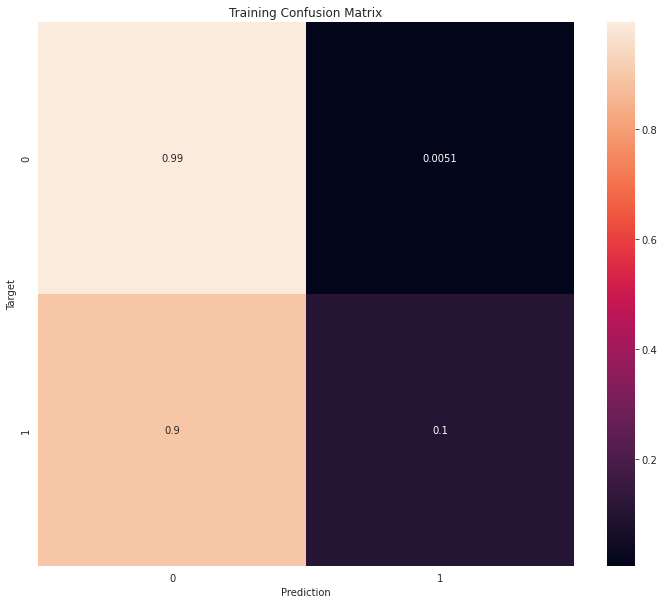

In [43]:
predict_and_plot(X_train, train_df[target_col], 'Training');

Accuracy: 84.55%


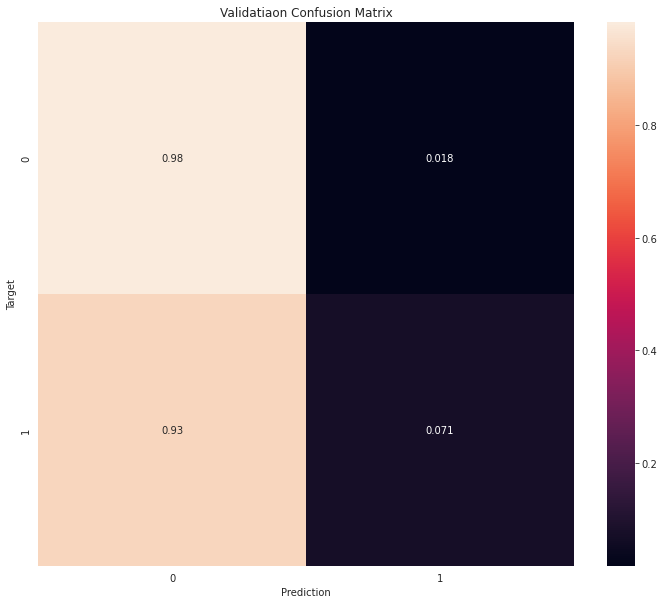

In [44]:
predict_and_plot(X_val, val_df[target_col], 'Validatiaon');

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC)')

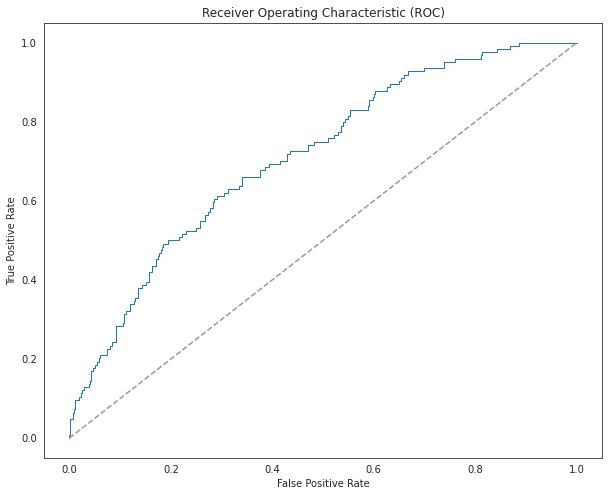

In [45]:
# ROC Curve Asessment
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
plt.figure(figsize=(10,8))
probas_ = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')

In [46]:
logreg = model
logreg.fit(train_df[valid_col], train_df[target_col])
log_odds = logreg.coef_[0]
pd.DataFrame(log_odds, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

coef
prevalentStroke  0.794055
BPMeds           0.601601
age              0.511395
male             0.365691
cigsPerDay       0.353863
sysBP            0.328389
diabetes         0.285032
glucose          0.178475
prevalentHyp     0.158161
totChol          0.090757
education        0.006818
diaBP            0.004428
BMI             -0.025155
heartRate       -0.039491
currentSmoker   -0.155591

In [47]:
logreg = model
logreg.fit(X_test, y_test)
log_odds = logreg.coef_[0]
pd.DataFrame(log_odds, 
             X_test.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

coef
male             0.768012
diabetes         0.531553
prevalentStroke  0.507280
age              0.346794
sysBP            0.328221
prevalentHyp     0.256113
totChol          0.251417
heartRate        0.168479
currentSmoker    0.149790
BMI              0.136042
cigsPerDay       0.128468
BPMeds           0.079926
glucose          0.077916
diaBP           -0.190845
education       -0.259270

In [48]:
odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, 
             X_test.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)


coef
male             2.155477
diabetes         1.701572
prevalentStroke  1.660767
age              1.414526
sysBP            1.388495
prevalentHyp     1.291898
totChol          1.285846
heartRate        1.183503
currentSmoker    1.161591
BMI              1.145730
cigsPerDay       1.137086
BPMeds           1.083207
glucose          1.081032
diaBP            0.826261
education        0.771615